# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/home/tram/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux/Reacher.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.08999999798834324


### 4. Training Agent with DDPG

In this section, we train a DDPG-based agent that will learn and take actions in the environment. The neural networks for Actor and Critic are defined in file model.py. The DDPG-based agent is implemented in file agent.py. Run the cell below to import neccessary libraries and Agent class. Excluding the input and output layers, the neural networks for Actor and Critic have 3 hidden layers with (256, 128, 64) hidden nodes, respectively. 

In [5]:
import torch
from collections import deque
import matplotlib.pyplot as plt

from agent import Agent

agent = Agent(state_size, action_size, random_seed=42)

We implement the DDPG algorithm in the cell below to train the agent.

In [6]:
def ddpg(nb_episodes=5000, max_steps=10000):
    """Train the agent with DDPG algorithm
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    scores = []
    scores_deque = deque(maxlen=100)
    
    for i in range(nb_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        for t in range(max_steps):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_deque.append(score)       # save most recent score to compute the average
        scores.append(score)             # save score of the episode for plotting purpose  
        
        if i%20 == 0:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i, score, np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

Run the cell below to train the agent and plot the reward after solving the environment.

Episode 0	Score: 0.99	Average Score: 0.99
Episode 20	Score: 3.16	Average Score: 1.47
Episode 40	Score: 7.03	Average Score: 3.14
Episode 60	Score: 8.66	Average Score: 4.48
Episode 80	Score: 5.56	Average Score: 5.06
Episode 100	Score: 7.39	Average Score: 5.46
Episode 120	Score: 11.62	Average Score: 6.51
Episode 140	Score: 8.62	Average Score: 6.98
Episode 160	Score: 23.41	Average Score: 8.13
Episode 180	Score: 19.40	Average Score: 10.48
Episode 200	Score: 29.68	Average Score: 13.87
Episode 220	Score: 30.06	Average Score: 16.53
Episode 240	Score: 31.94	Average Score: 19.68
Episode 260	Score: 34.15	Average Score: 23.11
Episode 280	Score: 33.78	Average Score: 24.73
Episode 300	Score: 17.59	Average Score: 25.27
Episode 320	Score: 22.61	Average Score: 26.40
Episode 340	Score: 20.97	Average Score: 25.80
Episode 360	Score: 30.17	Average Score: 24.23
Episode 380	Score: 28.55	Average Score: 23.82
Episode 400	Score: 13.46	Average Score: 23.32
Episode 420	Score: 23.84	Average Score: 21.96
Episode 44

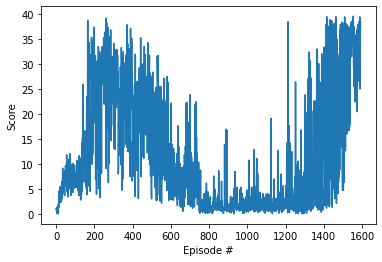

In [7]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [9]:
env.close()

### 5. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 